# Script IDF

## Librairies

In [335]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial

## Données et traitement: Extraction des Maximas par blocs: 

L'extraction des données est la même que pour les autres scripts, mais ici eviter d'utiliser temp=1 car la methode finale est basée sur l'idée d'un processus en minutes

In [336]:
Station = ['Aigle','Dole','Payerne','Fretaz','Pully','Nyon']
num_sta = 0 # Choix de la station
Annees = [['8095','9524'],['8024']]
Temporalité = ['Minutes','Heures']
Temporalité2 = ['10 Minutes', 'Heures']
time_format = ['%M','']
temp = 0 # Choix du type de données (Horaire: 1 ou par 10 minutes: 0)

if temp == 1:
    raise PermissionError("Choisissez temp=0")
df=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][0]+".txt", sep=";", low_memory=False)

# Si on a les données minutes alors elles sont séparées en plusieurs fichier de 1980 à 2025 et il convient de les fusionner
if Temporalité[temp] == 'Minutes':
    df_temp=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][1]+".txt", sep=";", low_memory=False)
    last_time = df['time'].iloc[-1]
    df_temp_no_overlap= df_temp[df_temp['time'] > last_time]
    df = pd.concat([df, df_temp_no_overlap], ignore_index=True) # Ici on fusionne les données de 80 à 95 avec 95 à 25

del df['stn']
df.time = pd.to_datetime(df['time'], yearfirst=True, utc=False, format='%Y%m%d%H'+time_format[temp])
df.replace('-', 0, inplace=True)
df = df[~df.time.dt.year.isin([2025, 1980])] # J'enlève les années incomplètes manuellement

In [352]:
N = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
treshold = 2

colonne_valeur = df.columns[1]

width_mobile = 35
num_mobiles = df['time'].dt.year.max() - df['time'].dt.year.min() - width_mobile + 1
first_year = df['time'].dt.year.min()
df[colonne_valeur] = pd.to_numeric(df[colonne_valeur])

check = np.zeros(shape=[num_mobiles, len(N)])

maximas = np.zeros(shape=[num_mobiles, len(N), width_mobile])
results = []

for j in range(num_mobiles):
    year_slice = []
    print(f'Years: {first_year+j}-{first_year+j+width_mobile} \n')
    for i,n in enumerate(N):
        treshold_temp = treshold/(n**(0.5))
        df_temp = df[(df['time'].dt.year >= first_year+j) & (df['time'].dt.year < first_year + j + width_mobile)].copy()
        rows_to_keep = len(df_temp) - (len(df_temp) % n)
        df_temp = df_temp.iloc[:rows_to_keep]
        df_temp['group'] = np.floor(df_temp.index / n)
        df_temp['averaged'] = df_temp.groupby('group')[colonne_valeur].transform('mean')
        exceeding = df_temp[df_temp['averaged'] > treshold_temp]
        unique_by_group = exceeding.drop_duplicates(subset='group')
        pdmaximas = unique_by_group['averaged'].values
        del df_temp
        print(len(pdmaximas))
        year_slice.append(np.sort(np.array(pdmaximas))[::-1])
    results.append(year_slice)

print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta]+'\n\tTemporalité: '+Temporalité2[temp])

Years: 1981-2016 

796
760
782
760
782
717
749
717
749
732
720
732
720
686
642
648
686
642
648
646
641
Years: 1982-2017 

646
641
Years: 1982-2017 

808
763
808
763
778
721
778
721
744
727
718
744
727
718
683
639
645
683
639
645
643
639
Years: 1983-2018 

643
639
Years: 1983-2018 

815
772
815
772
782
731
782
731
753
732
753
732
723
685
723
685
642
645
643
642
645
643
638
Years: 1984-2019 

809
638
Years: 1984-2019 

809
770
771
770
771
727
746
727
746
724
711
679
724
711
679
640
639
643
640
639
643
633
Years: 1985-2020 

817
633
Years: 1985-2020 

817
780
778
780
778
738
753
738
753
737
723
690
737
723
690
653
652
654
653
652
654
644
Years: 1986-2021 

821
644
Years: 1986-2021 

821
781
776
781
776
736
752
736
752
731
719
689
731
719
689
650
649
649
650
649
649
641
Years: 1987-2022 

823
641
Years: 1987-2022 

823
777
758
777
758
728
746
728
746
720
711
720
711
685
644
685
644
644
647
635
Years: 1988-2023 

644
647
635
Years: 1988-2023 

824
776
824
776
755
722
755
722
745
720
745
720

# Ajustement des données à la loi de Gumbel:

### Par la méthode de la log-likelihood

In [375]:
import lmoments3 as lm
import lmoments3.distr as lmdist
parametres = np.zeros(shape=[num_mobiles,len(N),3])

# data = your exceedances
for j in range(num_mobiles):
    for i, n in enumerate(N):
        fit = lmdist.gpa.lmom_fit(results[j][i])
        parametres[j, i, 0] = fit['c']
        parametres[j, i, 1] = fit['loc']
        parametres[j, i, 2] = fit['scale']

In [374]:
parametres = np.zeros(shape=[num_mobiles,len(N),3])

for j in range(num_mobiles):
    for i, n in enumerate(N):
        parametres[j,i] = stats.genpareto.fit(results[j][i])


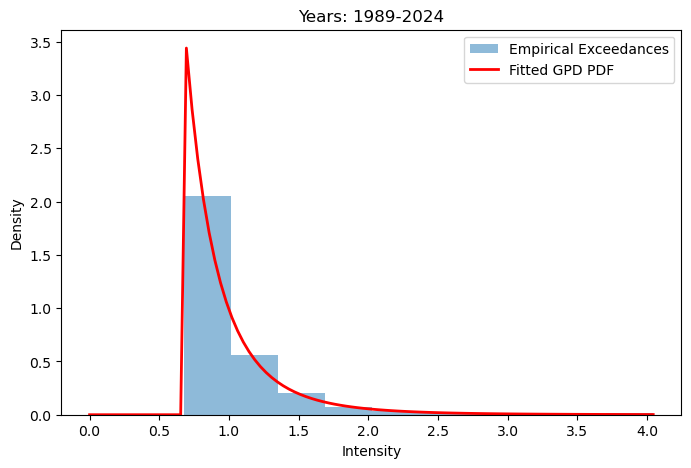

653


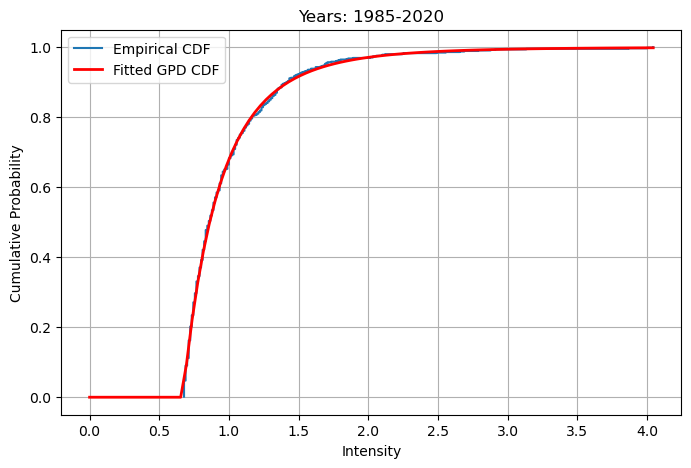

In [376]:
w=4
i=8

plt.figure(figsize=(8,5))
plt.hist(results[w][i], bins=10, density=True, alpha=0.5, label="Empirical Exceedances")
x = np.linspace(0, results[w][i].max(), 100)
plt.plot(x, stats.genpareto.pdf(x, parametres[w,i,0], loc=parametres[w,i,1], scale=parametres[w,i,2]), 'r-', lw=2, label="Fitted GPD PDF")
plt.title(f'Years: {first_year+j}-{first_year+j+width_mobile}')
plt.ylabel("Density")
plt.xlabel(f'Intensity')
plt.legend()
plt.show()

# Plot cumulative distribution (CDF)
plt.figure(figsize=(8,5))
# Empirical CDF
print(len(results[w][i]))
sorted_data = np.sort(results[w][i])
emp_cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
plt.step(sorted_data, emp_cdf, where='post', label="Empirical CDF")
# Fitted GPD CDF
plt.plot(x, stats.genpareto.cdf(x, parametres[w,i,0], loc=parametres[w,i,1], scale=parametres[w,i,2]), 'r-', lw=2, label="Fitted GPD CDF")
plt.xlabel(f'Intensity')
plt.ylabel("Cumulative Probability")
plt.title(f'Years: {first_year+w}-{first_year+w+width_mobile}')
plt.legend()
plt.grid(True)
plt.show()

## Plots Méthode numéro 2

In [377]:
def montana_complexe(a,b,n,N):
    return n+a*N**(b)

def montana_complexe_2D(a,b,n,N):
    return n[:,None] + a[:,None]*(N[None,:]**b[:,None])

def residuals_2(params, N, Frequencies):
    a = params[0]
    b = params[1]
    n = params[2]
    model = montana_complexe(a,b,n,N)
    residual = model - Frequencies
    return residual

In [378]:
import scipy.optimize

T = np.array([2,5,10,20,50,100])
a = np.zeros([num_mobiles,len(T)])
b = np.zeros([num_mobiles,len(T)])
n = np.zeros([num_mobiles,len(T)])
Frequencies = np.zeros(shape=[num_mobiles, len(N), len(T)])

for j in range(num_mobiles): 
    for i, t in enumerate(T):
        for k, l in enumerate(N):
            Frequencies[j,k,i] = stats.genpareto.ppf(1-1/t, parametres[j,k,0], loc=parametres[j,k,1], scale=parametres[j,k,2])
        print(Frequencies[j,:,i])
        result = scipy.optimize.least_squares(residuals_2, x0=[a[j,i],b[j,i],n[j,i]], args=(N, Frequencies[j,:,i]))
        a[j,i] = result.x[0]
        b[j,i] = result.x[1]
        n[j,i] = result.x[2]

[2.93997321 1.9273723  1.49699163 1.31448522 1.14309726 1.04664083
 0.95775087 0.90261993 0.85902869 0.80620034 0.77508565 0.73117881]
[4.30089635 2.77426603 2.08656011 1.80844983 1.54396035 1.41658373
 1.28394808 1.21219541 1.15493517 1.08197531 1.03794952 0.96686142]
[5.47089912 3.55485669 2.6499204  2.27425426 1.92095189 1.74545333
 1.58189006 1.49006994 1.41737938 1.32777229 1.26403852 1.1787713 ]
[6.77763229 4.48098188 3.33961282 2.8379859  2.37612892 2.12357247
 1.93260242 1.81224619 1.7185194  1.61101876 1.51664744 1.42483062]
[8.74228705 5.97539243 4.49420732 3.76905091 3.12583606 2.71168431
 2.4933109  2.31828412 2.18580043 2.05273733 1.89661421 1.81198374]
[10.43132549  7.352806    5.59747643  4.64703732  3.83089787  3.2345004
  3.00545076  2.77250308  2.60023947  2.44643908  2.22342333  2.16008568]
[2.94571688 1.94308675 1.50432682 1.31855777 1.14652804 1.04884882
 0.96011299 0.90437053 0.85969584 0.80643594 0.77485716 0.73035547]
[4.33800696 2.8145992  2.10965744 1.82368324

### Plot de la deuxième méthode

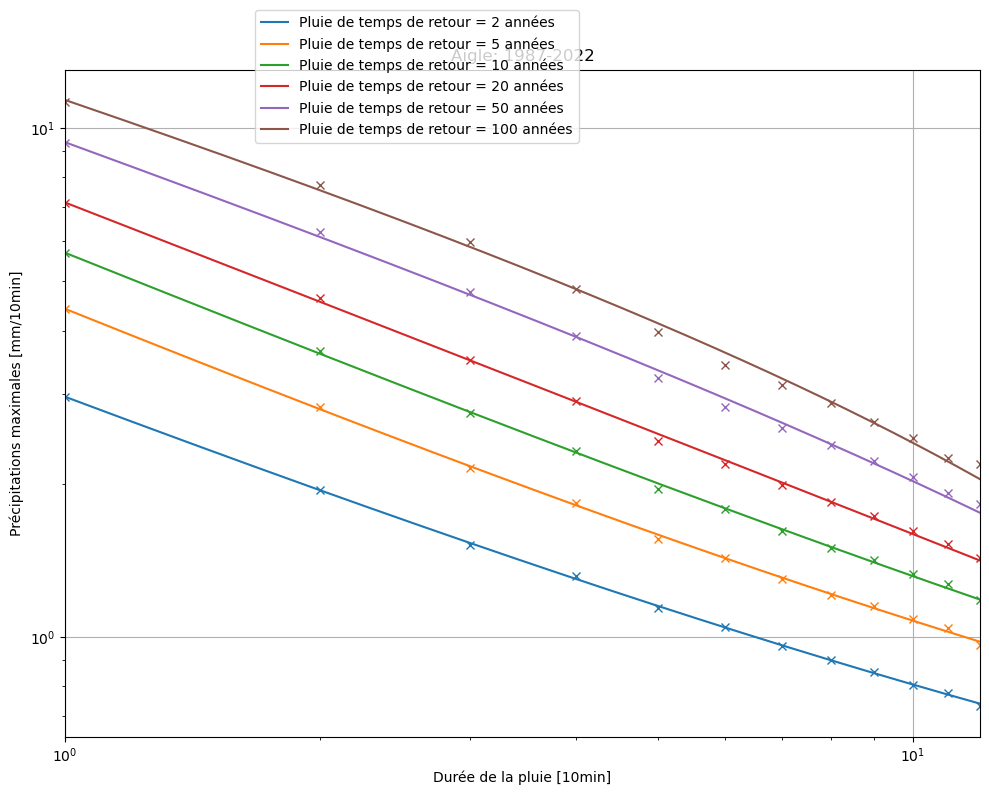

In [379]:
plt.figure(figsize=(10,8))
plt.subplot()
j = 6
for i, t in enumerate(T):
    p1, = plt.plot(np.linspace(N[0],N[-1],1000), montana_complexe(a[j,i],b[j,i],n[j,i],np.linspace(N[0],N[-1],1000)), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    plt.plot(N, Frequencies[j,:,i],'x', color=color)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.title(Station[num_sta]+f': {first_year+j}-{first_year+j+width_mobile}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(N[0],N[-1])
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(0.2,1.1))
plt.tight_layout()
plt.show()

# Computing the trend

In [380]:
def curves_diff(i1,i2,agg,precision):
    N = np.arange(agg[0],agg[-1],precision)
    mtn1 = montana_complexe_2D(a[:,i1],b[:,i1],n[:,i1],N)
    mtn2 = montana_complexe_2D(a[:,i2],b[:,i2],n[:,i2],N)
    return np.sum(mtn2 - mtn1, axis=1) / len(N)

2
5
10
20
50
100


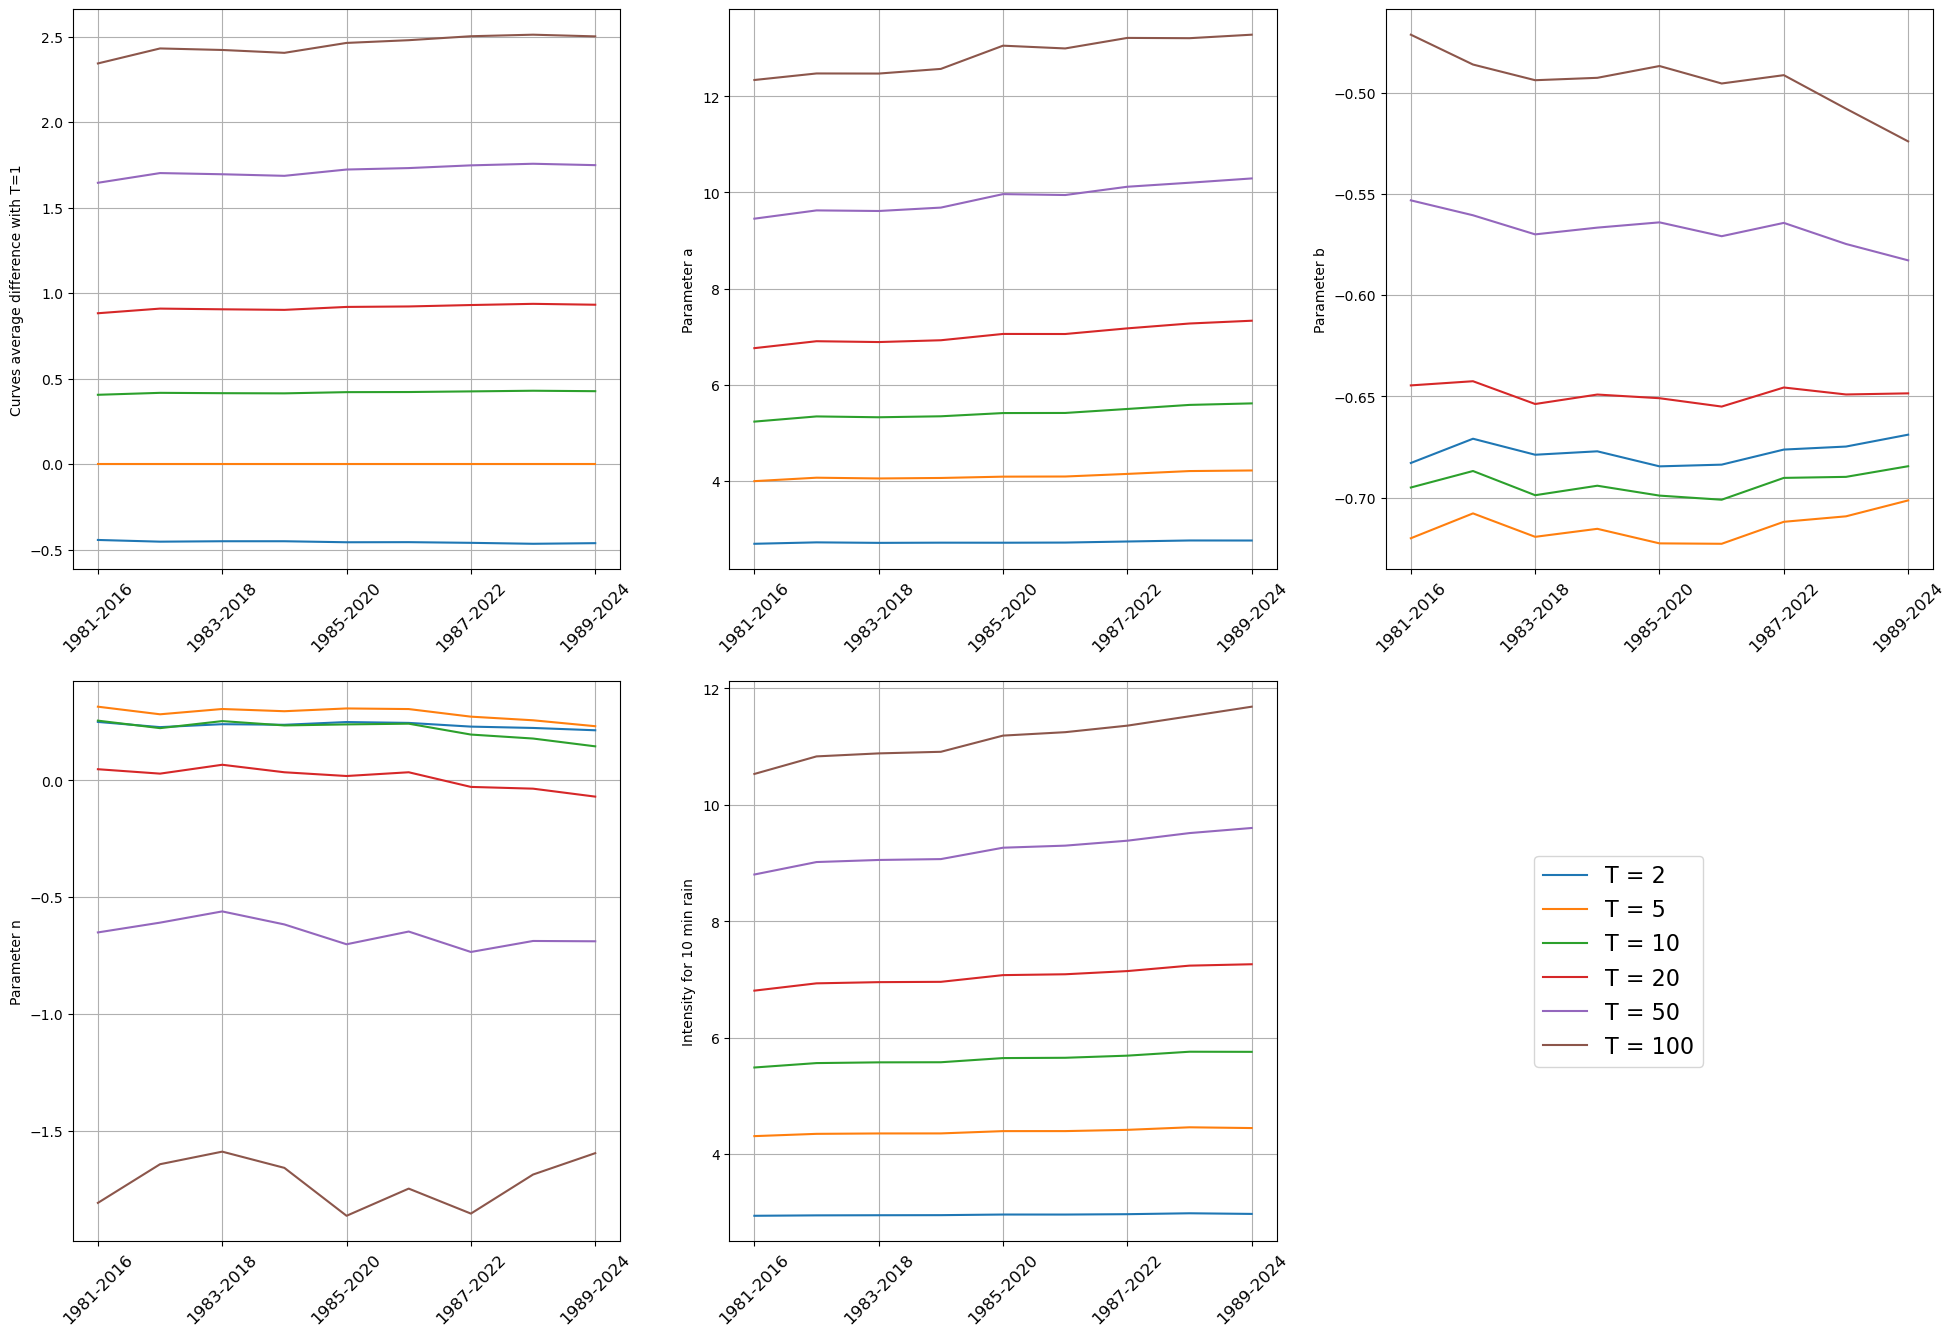

In [381]:
i1 = 1
k=0
x_labels = [f"{first_year+2*i}-{first_year+2*i+width_mobile}" for i in range(num_mobiles//2+1)]

plt.figure(figsize=(24, 16))

for i, t in enumerate(T):
    print(t)
    plt.subplot(2,3,1)
    plt.plot(1981+np.arange(num_mobiles),curves_diff(i1,i,N,0.0001), label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Curves average difference with T=1')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)


    plt.subplot(2,3,2)
    plt.plot(1981+np.arange(num_mobiles),a[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter a')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)


    plt.subplot(2,3,3)
    plt.plot(1981+np.arange(num_mobiles),b[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter b')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,4)
    plt.plot(1981+np.arange(num_mobiles),n[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter n')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,5)
    plt.plot(1981+np.arange(num_mobiles), montana_complexe(a[:,i], b[:,i], n[:,i], N[k]), label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Intensity for 10 min rain')
    plt.legend(loc='center right', bbox_to_anchor=(1.8,0.5), fontsize=16)
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)